In [20]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn import preprocessing

%matplotlib inline

Класс моделей ARIMA недостаточно богат для наших данных: с их помощью, например, никак нельзя учесть взаимосвязи между рядами. Это можно сделать с помощью векторной авторегрессии VARIMA, но её питоновская реализация не позволяет использовать регрессионные признаки. Кроме того, авторегрессионный подход не позволяет учитывать, например, взаимодействия между сезонными компонентами. Вы могли заметить, что форма суточных сезонных профилей в будни и выходные немного разная; явно моделировать этот эффект с помощью ARIMA не получится.

Нам нужна более сложная модель. Давайте займёмся сведением задачи массового прогнозирования рядов к регрессионной постановке! Вам понадобится много признаков. Некоторые из них у вас уже есть — это:
<ol>
<li>идентификатор географической зоны
<li>дата и время
<li>количество поездок в периоды, предшествующие прогнозируемому
<li>синусы, косинусы и тренды, которые вы использовали внутри регрессионной компоненты ARIMA
<li>Кроме того, не спешите выбрасывать построенный вами на прошлой неделе прогнозы — из них может получиться хороший признак для регрессии!
</ol>



Вы можете попробовать разные регрессионный модели, но хорошие результаты, скорее всего, дадут такие, которые будут позволять признакам взаимодействовать друг с другом.

Поскольку прогноз нужен на 6 часов вперёд, проще всего будет построить 6 независимых регрессионных моделей — одна для прогнозирования y^T+1|T, другая для y^T+2|T и т.д.

<ol>Чтобы сдать задание, выполните следующую последовательность действий.
<li>Для каждой из шести задач прогнозирования y^T+i|T,i=1,…,6 сформируйте выборки. Откликом будет yT+i при всевозможных значениях T, а признаки можно использовать следующие:
<ul>
<li>идентификатор географической зоны — категориальный
<li>год, месяц, день месяца, день недели, час — эти признаки можно пробовать брать и категориальными, и непрерывными, можно даже и так, и так (done)
<li>синусы, косинусы и тренды, которые вы использовали внутри регрессионной компоненты ARIMA (done)
<li>сами значения прогнозов ARIMA y^T+i|TARIMA
<li>количество поездок из рассматриваемого района в моменты времени yT,yT−1,…,yT−K (параметр K можно подбирать; попробуйте начать, например, с 6)
<li>количество поездок из рассматриваемого района в моменты времени yT−24,yT−48,…,yT−24∗Kd (параметр Kd можно подбирать; попробуйте начать, например, с 2)
<li>суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц
</ul>
Будьте внимательны при создании признаков — все факторы должны быть рассчитаны без использования информации из будущего: при прогнозировании y^T+i|T,i=1,…,6 вы можете учитывать только значения y до момента времени T включительно.

<li>Разбейте каждую из шести выборок на три части:

    обучающая, на которой будут настраиваться параметры моделей — всё до апреля 2016
    тестовая, на которой вы будете подбирать значения гиперпараметров — май 2016
    итоговая, которая не будет использоваться при настройке моделей вообще — июнь 2016

<li>Выберите вашу любимую регрессионную модель и настройте её на каждом из шести наборов данных, подбирая гиперпараметры на мае 2016. Желательно, чтобы модель:

    допускала попарные взаимодействия между признаками
    была устойчивой к избыточному количеству признаков (например, использовала регуляризаторы)

<li>Выбранными моделями постройте для каждой географической зоны и каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 прогнозы на 6 часов вперёд; посчитайте в ноутбуке ошибку прогноза по следующему функционалу:
Qmay=1R∗739∗6∑r=1R∑T=2016.04.3023:002016.05.3117:00∑i=16y^T|T+ir−yT+ir.
Убедитесь, что ошибка полученных прогнозов, рассчитанная согласно функционалу Q, определённому на прошлой неделе, уменьшилась по сравнению с той, которую вы получили методом индивидуального применения моделей ARIMA. Если этого не произошло, попробуйте улучшить ваши модели.

<li>Итоговыми моделями постройте прогнозы для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 и запишите все результаты в один файл в формате geoID, histEndDay, histEndHour, step, y. Здесь geoID — идентификатор зоны, histEndDay — день конца истории в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

<li>Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.

<li>Загрузите ноутбук в форму.

Подгружаем данные

In [4]:
# id нужных регионов
regsDf = pd.read_csv('../crowdRegs.csv',names=['id','regId']);  

# временные ряды для этих регионов
df = pd.read_pickle('../loadData/crowdRegs3.pcl')
df.columns = regsDf.regId.values.astype('str')

Наверное, оптимальный способ - пройтись по всем регионам, сформировать требуемую выборку, а потом - состыковать. 
Вероятно, в процессе работы получится векторизовать это действие.
Пожалуй, имеет смысл сначала для всего фрейма добавить общие для всех колонок признаки (тренд, гармоники, даты, дни недели)

In [55]:
#parameters:
Kw = 5
Ka = 2


df2 = df.copy()
df2 = df2.assign(linear = (df2.index - datetime.datetime(2014,1,1,0,0,0))/np.timedelta64(1, 'h'))

# час — эти признаки можно пробовать брать и категориальными
# и непрерывными, можно даже и так, и так

# добавляем гармонические фичи
for ind in range(1,Kw+1):
    df2['weekCos'+str(ind)]= np.cos(np.pi*df2.linear*ind/168);
    df2['weekSin'+str(ind)]= np.sin(np.pi*df2.linear*ind/168);
for ind in range(1,Ka+1):
    df2['yearCos'+str(ind)]= np.cos(2*np.pi*df2.linear*ind/8766);
    df2['yearSin'+str(ind)]= np.sin(2*np.pi*df2.linear*ind/8766);

# добавляем числовое и категориальные свойства для дней недели
df2 = df2.assign(dayOfWeek = df2.index.dayofweek)
lbDays = preprocessing.LabelBinarizer()
lbDays.fit(list(np.arange(6)))
DoW = pd.DataFrame(lbDays.transform(df2.index.dayofweek),columns = ['dayOfWeek_'+str(x) for x in np.arange(6)],
                   index = df2.index)      
df2 = df2.merge(DoW,left_index=True,right_index=True)

# добавляем dummy variables для месяца
df2 = df2.assign(month = df2.index.month)
lbMonths = preprocessing.LabelBinarizer()
lbMonths.fit(list(np.arange(12)))
Months = pd.DataFrame(lbMonths.transform(df2.index.month),columns = ['month_'+str(x) for x in np.arange(12)],
                      index = df2.index)      
df2 = df2.merge(Months,left_index=True,right_index=True);

# добавляем год (вещественный)
df2 = df2.assign(year = df.index.year)

# добавляем день месяца (вещественный)
df2 = df2.assign(day = df.index.day)

# добавляем час (вещественный и категориальный)
df2 = df2.assign(hour = df.index.hour)
lbHours = preprocessing.LabelBinarizer()
lbHours.fit(list(np.arange(24)))
Hours = pd.DataFrame(lbHours.transform(df2.index.hour),columns = ['hour_'+str(x) for x in np.arange(24)],
                   index = df2.index)      
df2 = df2.merge(Hours,left_index=True,right_index=True)



#loop over the columns
#regs = df.columns
#tReg = '1075' # test colums
#testDf = df.loc[:,tReg].to #.rename(columns={'index':'date',tReg:'trips'})
#testDf = testDf.assign('year' = )
#testDf.head()
df2.tail(10)

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
2016-06-30 14:00:00,109,236,103,107,212,262,283,233,348,115,...,1,0,0,0,0,0,0,0,0,0
2016-06-30 15:00:00,86,199,68,78,213,223,236,230,314,127,...,0,1,0,0,0,0,0,0,0,0
2016-06-30 16:00:00,81,152,85,86,179,160,181,178,267,91,...,0,0,1,0,0,0,0,0,0,0
2016-06-30 17:00:00,82,139,100,80,255,226,218,280,404,154,...,0,0,0,1,0,0,0,0,0,0
2016-06-30 18:00:00,88,173,117,75,309,266,272,343,507,262,...,0,0,0,0,1,0,0,0,0,0
2016-06-30 19:00:00,116,190,135,132,395,308,401,336,496,260,...,0,0,0,0,0,1,0,0,0,0
2016-06-30 20:00:00,104,142,149,141,333,368,390,385,560,247,...,0,0,0,0,0,0,1,0,0,0
2016-06-30 21:00:00,151,162,145,135,359,422,460,541,672,259,...,0,0,0,0,0,0,0,1,0,0
2016-06-30 22:00:00,106,168,103,125,317,476,405,508,578,259,...,0,0,0,0,0,0,0,0,1,0
2016-06-30 23:00:00,85,130,86,113,256,428,483,531,631,210,...,0,0,0,0,0,0,0,0,0,1


Теперь делаем индивидуальную обработку для каждого региона
<ol>
<li> добавляем идентификатор географической зоны — категориальный
<li> количество поездок из рассматриваемого района в моменты времени yT,yT−1,…,yT−K (параметр K можно подбирать; попробуйте начать, например, с 6)
<li> количество поездок из рассматриваемого района в моменты времени yT−24,yT−48,…,yT−24∗Kd (параметр Kd можно подбирать; попробуйте начать, например, с 2)
<li>суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц 
2) 
</ol>

In [85]:
commonFeatures = ['linear','weekCos1', 'weekSin1', 'weekCos2', 'weekSin2', 'weekCos3','weekSin3', 'weekCos4',
       'weekSin4', 'weekCos5', 'weekSin5','yearCos1', 'yearSin1', 'yearCos2', 'yearSin2', 'dayOfWeek','dayOfWeek_0',
       'dayOfWeek_1', 'dayOfWeek_2', 'dayOfWeek_3','dayOfWeek_4', 'dayOfWeek_5', 'month', 'month_0', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7','month_8', 'month_9', 'month_10', 'month_11',
       'year', 'day', 'hour','hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5','hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17','hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']

In [86]:
tReg = '1075'

In [106]:
df3 = df2.loc[:,tReg.split() + commonFeatures].rename(columns={tReg:'y'})
#создаём шесть целевые переменных для каждого конца истории
for targetVar in np.arange(1,7):
    name = 'y'+str(targetVar)
    df3.loc[:,name] = df3.y.shift(targetVar)
    
df3.fillna(0,inplace=True)

In [120]:
# parameters:
Kh = 6 # количество отслеживаемых прошлых суточных лагов "назад"
Kp = 2 # количество отслеживаемых прошлых периодических лагов (период 24 часа)

for timeLag in np.arange(1,Kh+1):
    name = 'hourLag_'+str(timeLag)
    df3.loc[:,name] = df3.y.shift(periods=timeLag)
    
for timeLag in np.arange(1,Kp+1):
    name = 'periodicLag_'+str(timeLag)
    df3.loc[:,name] = df3.y.shift(periods=timeLag*24)
    
df3.fillna(0,inplace=True)        
df3.head(50)    

,y,linear,weekCos1,weekSin1,weekCos2,weekSin2,weekCos3,weekSin3,weekCos4,weekSin4,...,hourLag_3,hourLag_4,hourLag_5,hourLag_6,periodicLag_1,periodicLag_2,sum12,sum24,sumWeek,sumMonth
2014-01-01 00:00:00,87,0.0,1.000000,0.000000,1.000000e+00,0.000000,1.000000e+00,0.000000,1.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,87.0,87.0,87.0,87.0
2014-01-01 01:00:00,92,1.0,0.999825,0.018699,9.993007e-01,0.037391,9.984268e-01,0.056070,9.972038e-01,7.473009e-02,...,0.0,0.0,0.0,0.0,0.0,0.0,179.0,179.0,179.0,179.0
2014-01-01 02:00:00,108,2.0,0.999301,0.037391,9.972038e-01,0.074730,9.937122e-01,0.111964,9.888308e-01,1.490423e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,287.0,287.0,287.0,287.0
2014-01-01 03:00:00,77,3.0,0.998427,0.056070,9.937122e-01,0.111964,9.858710e-01,0.167506,9.749279e-01,2.225209e-01,...,87.0,0.0,0.0,0.0,0.0,0.0,364.0,364.0,364.0,364.0
2014-01-01 04:00:00,47,4.0,0.997204,0.074730,9.888308e-01,0.149042,9.749279e-01,0.222521,9.555728e-01,2.947552e-01,...,92.0,87.0,0.0,0.0,0.0,0.0,411.0,411.0,411.0,411.0
2014-01-01 05:00:00,22,5.0,0.995632,0.093364,9.825665e-01,0.185912,9.609173e-01,0.276836,9.308737e-01,3.653410e-01,...,108.0,92.0,87.0,0.0,0.0,0.0,433.0,433.0,433.0,433.0
2014-01-01 06:00:00,10,6.0,0.993712,0.111964,9.749279e-01,0.222521,9.438833e-01,0.330279,9.009689e-01,4.338837e-01,...,77.0,108.0,92.0,87.0,0.0,0.0,443.0,443.0,443.0,443.0
2014-01-01 07:00:00,18,7.0,0.991445,0.130526,9.659258e-01,0.258819,9.238795e-01,0.382683,8.660254e-01,5.000000e-01,...,47.0,77.0,108.0,92.0,0.0,0.0,461.0,461.0,461.0,461.0
2014-01-01 08:00:00,19,8.0,0.988831,0.149042,9.555728e-01,0.294755,9.009689e-01,0.433884,8.262388e-01,5.633201e-01,...,22.0,47.0,77.0,108.0,0.0,0.0,480.0,480.0,480.0,480.0
2014-01-01 09:00:00,28,9.0,0.985871,0.167506,9.438833e-01,0.330279,8.752234e-01,0.483719,7.818315e-01,6.234898e-01,...,10.0,22.0,47.0,77.0,0.0,0.0,508.0,508.0,508.0,508.0


In [121]:
# суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц
df3.loc[:,'sum12'] = df3.y.rolling(window = 12, min_periods = 1).sum()
df3.loc[:,'sum24'] = df3.y.rolling(window = 24, min_periods = 1).sum()
df3.loc[:,'sumWeek'] = df3.y.rolling(window = 168, min_periods = 1).sum()
df3.loc[:,'sumMonth'] = df3.y.rolling(window = 720, min_periods = 1).sum()
df3.head()

,y,linear,weekCos1,weekSin1,weekCos2,weekSin2,weekCos3,weekSin3,weekCos4,weekSin4,...,hourLag_3,hourLag_4,hourLag_5,hourLag_6,periodicLag_1,periodicLag_2,sum12,sum24,sumWeek,sumMonth
2014-01-01 00:00:00,87,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,87.0,87.0,87.0,87.0
2014-01-01 01:00:00,92,1.0,0.999825,0.018699,0.999301,0.037391,0.998427,0.056070,0.997204,0.074730,...,0.0,0.0,0.0,0.0,0.0,0.0,179.0,179.0,179.0,179.0
2014-01-01 02:00:00,108,2.0,0.999301,0.037391,0.997204,0.074730,0.993712,0.111964,0.988831,0.149042,...,0.0,0.0,0.0,0.0,0.0,0.0,287.0,287.0,287.0,287.0
2014-01-01 03:00:00,77,3.0,0.998427,0.056070,0.993712,0.111964,0.985871,0.167506,0.974928,0.222521,...,87.0,0.0,0.0,0.0,0.0,0.0,364.0,364.0,364.0,364.0
2014-01-01 04:00:00,47,4.0,0.997204,0.074730,0.988831,0.149042,0.974928,0.222521,0.955573,0.294755,...,92.0,87.0,0.0,0.0,0.0,0.0,411.0,411.0,411.0,411.0


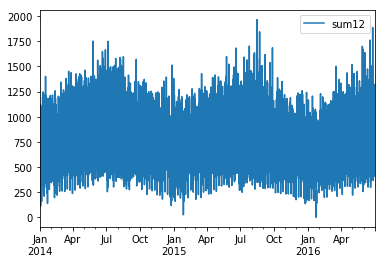

In [123]:
df3.plot(y=['sum12'])

In [124]:
# теперь надо добавлять данные из SARIMAX модели